In [2]:
import json
import math
import pickle

from utils import read_lines

In [3]:
PATH = json.load(open('../path_config.json'))

#### Read XSum

In [4]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [5]:
from tqdm import tqdm

In [6]:
data = json.load(open('../data/annotated_with_probability_200.json', 'r'))
print(len(data))

200


In [7]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_bos': 0.02984619140625,
   'bart.large.xsum': 0.0200347900390625,
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 1.9073486328125e-06,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.092529296875},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'xsum_cmlm_bos': 0.0843505859375,
   'bart.large.xsum': 0.06317138671875,
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 4.7087669372558594e-05,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.003948211669921875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent': 

#### Prior/Posterior Distribution Diagram

In [8]:
%matplotlib inline

from draw import plot_scatter

In [9]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        prior_posterior.append(e)

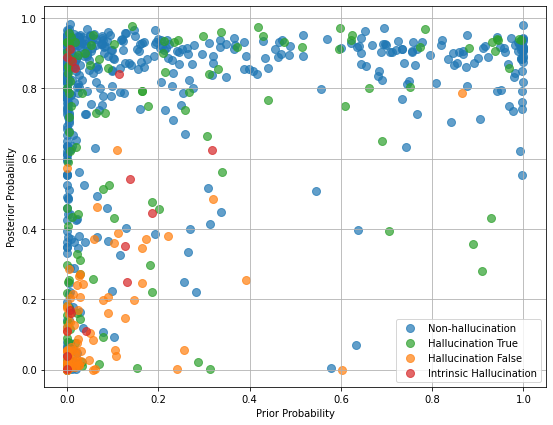

In [10]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]

input_data_log_scale = [[], [], [], []]
for i in range(len(input_data)):
    for p in input_data[i]:
#         prior, posterior = max(p[0], 1e-6), max(p[1], 1e-6)
#         input_data_log_scale[i].append((-math.log(prior), -math.log(posterior)))
        input_data_log_scale[i].append((p[0], p[1]))
        
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data_log_scale, labels)

#### Compare CMLM

In [11]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['text.usetex'] = False

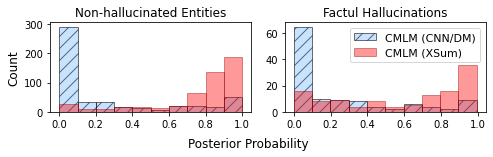

In [12]:
n_bins = 10
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.0))

my_blue = (153/255, 204/255, 1.0, 0.55)
my_edge = (0., 0., 0., 0.55)

priors_0 = [p['prior'] for p in prior_posterior if p['label'] == 0]
posteriors_0 = [p['posterior'] for p in prior_posterior if p['label'] == 0]
_, bins, _ = ax0.hist(priors_0, n_bins, density=False, histtype='bar', label='CMLM trained on CNN/DM',
                      facecolor=my_blue, edgecolor=my_edge, hatch='//')
ax0.hist(posteriors_0, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM trained on XSum', edgecolor='darkred', alpha=0.40)
ax0.set_ylabel('Count', fontsize=12)
ax0.set_title('Non-hallucinated Entities', fontsize=12)

priors_1 = [p['prior'] for p in prior_posterior if p['label'] == 1]
posteriors_1 = [p['posterior'] for p in prior_posterior if p['label'] == 1]
_, bins, _ = ax1.hist(priors_1, n_bins, density=False, histtype='bar', 
                      facecolor=my_blue, label='CMLM (CNN/DM)', edgecolor=my_edge, hatch='//')
ax1.hist(posteriors_1, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM (XSum)', edgecolor='darkred', alpha=0.40)
ax1.legend(prop={'size': 11})
ax1.set_title('Factul Hallucinations', fontsize=12)

fig.text(0.5, -0.05, 'Posterior Probability', ha='center', fontsize=12)
# fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()

plt.savefig("figures/" + 'hist_2cmlm' +'.pdf', bbox_inches="tight")
plt.show()

In [13]:
# selected_entities = []
# for e in prior_posterior:
#     if e['label'] == 1:
#         if e['prior'] > 1e-5 and math.log(e['posterior'] / e['prior']) > 5:
#             selected_entities.append(e)
#         if e['prior'] > 0. and math.log(e['posterior'] / e['prior']) < 0:
#             selected_entities.append(e)
#         elif e['posterior'] - e['prior'] > 0.5:
#             selected_entities.append(e)

In [14]:
# print(len(selected_entities))
# print(selected_entities[0])

In [15]:
# json.dump(selected_entities, open('sigma_entities.json', 'w'))

#### Get Average Entropy

In [16]:
import math

from draw import plot_hist

In [17]:
for l in range(3):
    posteriors = [p['prior'] for p in prior_posterior if p['label'] == l]
    print('- label {}: {}'.format(l, -math.log(sum(posteriors) / len(posteriors))))

- label 0: 1.404350662654027
- label 1: 1.4591605446529026
- label 2: 2.790782965517991


In [18]:
threshold = 0.0001
posteriors = [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['posterior'] > threshold:
            posteriors[l].append(p['posterior'])

In [19]:
threshold = 1e-7
priors= [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['prior'] > threshold:
            priors[l].append(p['prior'])

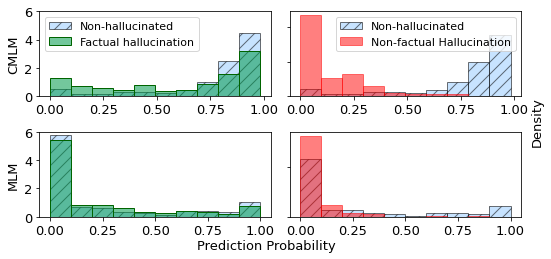

In [20]:
plot_hist('histogram', posteriors, priors, save_fig=True)

#### Evaluate Baseline Models

In [21]:
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score

In [22]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_bos': 0.019073486328125,
 'bart.large.xsum': 0.0927734375,
 'cnndm_cmlm_cedar': 0.80859375,
 'cnndm_cmlm_scratch_cedar_warmup_10000': 0.00147247314453125,
 'xsum_cmlm_scratch_cedar_warmup_20000': 0.01239013671875,
 'id': 8805,
 'prior': 1.1265277862548828e-05,
 'posterior': 0.019073486328125}

In [23]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [24]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [25]:
print(balanced_accuracy_score(factual_label, overlap_preds))
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

0.8425057270644704
              precision    recall  f1-score   support

 Non-factual     0.3517    0.9326    0.5108        89
     Factual     0.9873    0.7524    0.8540       618

    accuracy                         0.7751       707
   macro avg     0.6695    0.8425    0.6824       707
weighted avg     0.9073    0.7751    0.8108       707



In [26]:
print(balanced_accuracy_score([1 if i == 0 else 0 for i in hallucination_label], overlap_preds))
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

0.9378853861569292
                  precision    recall  f1-score   support

Non-hallucinated     0.8390    0.9519    0.8919       208
    Hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [27]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.1765    0.2022    0.1885        89
     Factual     0.8826    0.8641    0.8733       618

    accuracy                         0.7808       707
   macro avg     0.5296    0.5332    0.5309       707
weighted avg     0.7937    0.7808    0.7871       707



In [28]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.3529    0.1731    0.2323       208
    Hallucinated     0.7157    0.8677    0.7844       499

        accuracy                         0.6634       707
       macro avg     0.5343    0.5204    0.5083       707
    weighted avg     0.6090    0.6634    0.6220       707



### KNN Evaluation

In [29]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three, plot_three_with_boundary

In [30]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [31]:
n = 15
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=n)
print(balanced_accuracy_score(hallucination_label_reverse, knn_preds))
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

0.722334091259442
                  precision    recall  f1-score   support

    Hallucinated     0.6805    0.5529    0.6101       208
Non-hallucinated     0.8271    0.8918    0.8582       499

        accuracy                         0.7921       707
       macro avg     0.7538    0.7223    0.7342       707
    weighted avg     0.7840    0.7921    0.7852       707



In [32]:
knn_preds = leave_one_out_error(overlap_preds, posterior_probabilities, factual_label, n_neighbors=16)
print(balanced_accuracy_score(factual_label, knn_preds))
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

0.812761354132577
              precision    recall  f1-score   support

 Non-Factual     0.6224    0.6854    0.6524        89
     Factual     0.9540    0.9401    0.9470       618

    accuracy                         0.9081       707
   macro avg     0.7882    0.8128    0.7997       707
weighted avg     0.9123    0.9081    0.9099       707



In [33]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, true_label, n_neighbors=20)
print(balanced_accuracy_score(true_label, knn_preds))
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual', 'Non-factual'], digits=4))

0.5527129543132467
                  precision    recall  f1-score   support

Non-hallucinated     0.8028    0.9138    0.8547       499
         Factual     0.2308    0.0252    0.0455       119
     Non-factual     0.5079    0.7191    0.5953        89

        accuracy                         0.7397       707
       macro avg     0.5138    0.5527    0.4985       707
    weighted avg     0.6694    0.7397    0.6859       707



#### KNN with Three Features

In [34]:
import random

In [35]:
random.uniform(0.00, 0.01)

0.007511802472437351

In [36]:
def leave_one_out_error_three_features(prior_probs, posterior_probs, overlaps, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels) == len(overlaps)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')
        
#         x_mat = np.array(train_features)
#         y_vec = np.array(train_labels)
#         classifier.fit(x_mat, y_vec)

#         test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        
        x_mat = np.array(train_features)
        stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
        x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i] / stds[0],
                                   posterior_probs[i] / stds[1],
                                   overlaps[i]] / stds[2]])
        
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [37]:
hal_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, n_neighbors=15)
print(balanced_accuracy_score(hallucination_label_reverse, hal_preds))
print(classification_report(hallucination_label_reverse, hal_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

0.9378853861569292
                  precision    recall  f1-score   support

    Hallucinated     0.8390    0.9519    0.8919       208
Non-hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [38]:
fact_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, factual_label, n_neighbors=30)
print(balanced_accuracy_score(factual_label, fact_preds))
print(classification_report(factual_label, fact_preds, target_names=['Non-Factual', 'Factual'], digits=4))

0.7647176466310317
              precision    recall  f1-score   support

 Non-Factual     0.7143    0.5618    0.6289        89
     Factual     0.9388    0.9676    0.9530       618

    accuracy                         0.9165       707
   macro avg     0.8265    0.7647    0.7910       707
weighted avg     0.9105    0.9165    0.9122       707



In [39]:
merged_preds = []
for h, f in zip(hal_preds, fact_preds):
    if h == 0 and f == 0:
        merged_preds.append(2)
    elif h == 1 and f == 1:
        merged_preds.append(0)
    elif h == 0 and f == 1:
        merged_preds.append(1)
    elif h == 1 and f == 0:
        print('error')
    else:
        raise Exception("unexpected value!!!")

print(balanced_accuracy_score(true_label, merged_preds))
print(classification_report(true_label, merged_preds, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.7781283146660298
                  precision    recall  f1-score   support

Non-hallucinated     0.9788    0.9238    0.9505       499
    Factual hal.     0.6084    0.8487    0.7088       119
Non-factual hal.     0.7143    0.5618    0.6289        89

        accuracy                         0.8656       707
       macro avg     0.7672    0.7781    0.7627       707
    weighted avg     0.8831    0.8656    0.8693       707



In [40]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, true_label, n_neighbors=15)
print(balanced_accuracy_score(true_label, knn_preds))
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.751942559465073
                  precision    recall  f1-score   support

Non-hallucinated     0.9685    0.9238    0.9456       499
    Factual hal.     0.5951    0.8151    0.6879       119
Non-factual hal.     0.6765    0.5169    0.5860        89

        accuracy                         0.8543       707
       macro avg     0.7467    0.7519    0.7399       707
    weighted avg     0.8689    0.8543    0.8570       707



#### KNN on Test Set

In [41]:
import random

In [130]:
random.seed(0)

In [131]:
prior_probabilities, posterior_probabilities, overlap_preds
assert len(prior_probabilities) == len(posterior_probabilities)
assert len(overlap_preds) == len(factual_label)

train_features, train_labels, train_true_labels = [], [], []
test_features, test_labels, test_true_labels = [], [], []

for i in range(len(prior_probabilities)):
    if random.random() >= 0.3:
        train_features.append([prior_probabilities[i], posterior_probabilities[i], overlap_preds[i]])
        train_labels.append(factual_label[i])
        train_true_labels.append(true_label[i])
    else:
        test_features.append([prior_probabilities[i], posterior_probabilities[i], overlap_preds[i]])
        test_labels.append(factual_label[i])
        test_true_labels.append(true_label[i])
        
print(len(train_features))
print(len(test_features))
classifier = neighbors.KNeighborsClassifier(n_neighbors=17, algorithm='auto')

500
207


In [132]:
# fit (three features)
x_mat = np.array(train_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
y_vec = np.array(train_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=17)

In [133]:
# predict (three features)
x_mat = np.array(test_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
Z = classifier.predict(x_mat)

In [134]:
print(balanced_accuracy_score(test_labels, Z))
print(classification_report(test_labels, Z, target_names=['Non-Factual', 'Factual'], digits=4))

0.8777173913043479
              precision    recall  f1-score   support

 Non-Factual     0.5938    0.8261    0.6909        23
     Factual     0.9771    0.9293    0.9526       184

    accuracy                         0.9179       207
   macro avg     0.7854    0.8777    0.8218       207
weighted avg     0.9345    0.9179    0.9236       207



In [135]:
pickle.dump(classifier, open('classifiers/knn_classifier_trained.pkl', 'wb'))

In [48]:
# fit (three features, three labels)
x_mat = np.array(train_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
y_vec = np.array(train_true_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=15)

In [49]:
# predict (three features, three labels)
x_mat = np.array(test_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
Z = classifier.predict(x_mat)

In [50]:
print(balanced_accuracy_score(test_true_labels, Z))
print(classification_report(test_true_labels, Z, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.8217737285203551
                  precision    recall  f1-score   support

Non-hallucinated     0.9924    0.9034    0.9458       145
    Factual hal.     0.7105    0.6923    0.7013        39
Non-factual hal.     0.5405    0.8696    0.6667        23

        accuracy                         0.8599       207
       macro avg     0.7478    0.8218    0.7713       207
    weighted avg     0.8891    0.8599    0.8688       207



In [51]:
# fit (two features)
train_features_two = [[f[0], f[1]] for f in train_features]
test_features_two = [[f[0], f[1]] for f in test_features]
x_mat = np.array(train_features_two)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
y_vec = np.array(train_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=15)

In [52]:
# predict (two features)
x_mat = np.array(test_features_two)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
Z = classifier.predict(x_mat)

In [53]:
print(balanced_accuracy_score(test_labels, Z))
print(classification_report(test_labels, Z, target_names=['Non-Factual', 'Factual'], digits=4))

0.7255434782608696
              precision    recall  f1-score   support

 Non-Factual     0.4800    0.5217    0.5000        23
     Factual     0.9396    0.9293    0.9344       184

    accuracy                         0.8841       207
   macro avg     0.7098    0.7255    0.7172       207
weighted avg     0.8885    0.8841    0.8862       207



In [54]:
# LM baseline
lm_baseline = []
for f in test_features:
    if f[1] > f[0]:
        lm_baseline.append(1)
    else:
        lm_baseline.append(0)
print(balanced_accuracy_score(test_labels, lm_baseline))
print(classification_report(test_labels, lm_baseline, target_names=['Non-Factual', 'Factual'], digits=4))

0.5461956521739131
              precision    recall  f1-score   support

 Non-Factual     0.1786    0.2174    0.1961        23
     Factual     0.8994    0.8750    0.8871       184

    accuracy                         0.8019       207
   macro avg     0.5390    0.5462    0.5416       207
weighted avg     0.8193    0.8019    0.8103       207



In [55]:
# overlap
print(balanced_accuracy_score(test_labels, [i[2] for i in test_features]))
print(classification_report(test_labels, [i[2] for i in test_features], target_names=['Non-Factual', 'Factual'], digits=4))

0.8342391304347827
              precision    recall  f1-score   support

 Non-Factual     0.2933    0.9565    0.4490        23
     Factual     0.9924    0.7120    0.8291       184

    accuracy                         0.7391       207
   macro avg     0.6429    0.8342    0.6390       207
weighted avg     0.9147    0.7391    0.7869       207



#### SVM with RBF Kernel

In [56]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [57]:
def leave_one_out_error_svm(prior_probs, posterior_probs, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [58]:
def leave_one_out_error_svm_three_features(prior_probs, posterior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [59]:
def save_svm(posterior_probs, prior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    x_mat = np.array([posterior_probs, prior_probs, overlaps]).transpose()
    y_vec = np.array(labels)

    if linear:
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    else:
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(x_mat, y_vec)

    return clf

In [60]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label)
print(classification_report(factual_label, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.5278    0.6404    0.5787        89
 Non-factual     0.9466    0.9175    0.9318       618

    accuracy                         0.8826       707
   macro avg     0.7372    0.7790    0.7552       707
weighted avg     0.8939    0.8826    0.8873       707



In [61]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6890    0.5433    0.6075       208
Non-hallucinated     0.8250    0.8978    0.8599       499

        accuracy                         0.7935       707
       macro avg     0.7570    0.7205    0.7337       707
    weighted avg     0.7850    0.7935    0.7856       707



In [62]:
svm_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8390    0.9519    0.8919       208
 Non-factual     0.9788    0.9238    0.9505       499

    accuracy                         0.9321       707
   macro avg     0.9089    0.9379    0.9212       707
weighted avg     0.9376    0.9321    0.9333       707



In [63]:
svm_classifier = save_svm(posterior_probabilities, prior_probabilities, overlap_preds, factual_label)

In [64]:
# pickle.dump(svm_classifier, open('classifiers/svm_classifier.pkl', 'wb'))

#### Linear Model

In [65]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label, linear=True)
print(classification_report(factual_label, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.4471    0.4270    0.4368        89
 Non-factual     0.9180    0.9239    0.9210       618

    accuracy                         0.8614       707
   macro avg     0.6825    0.6755    0.6789       707
weighted avg     0.8587    0.8614    0.8600       707



In [66]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.6000    0.4615    0.5217       208
Non-hallucinated     0.7952    0.8717    0.8317       499

        accuracy                         0.7511       707
       macro avg     0.6976    0.6666    0.6767       707
    weighted avg     0.7378    0.7511    0.7405       707



In [67]:
linear_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8340    0.9423    0.8849       208
 Non-factual     0.9746    0.9218    0.9475       499

    accuracy                         0.9279       707
   macro avg     0.9043    0.9321    0.9162       707
weighted avg     0.9332    0.9279    0.9291       707



#### KNN Classification Boundaries

In [68]:
font = {'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

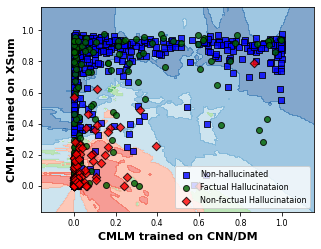

In [69]:
plot_three_with_boundary('entity_distribution_2cmlm',
                         posterior_probabilities, prior_probabilities, true_label,
                         colors=['blue', 'darkgreen', 'red'],
                         legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
                         x_label='CMLM trained on CNN/DM',
                         y_label='CMLM trained on XSum',
                         n_neighbors=16,
                         fig_size=(4.5, 3.5),
                         interval=0.25, h=0.05,
                         save_figure=True)

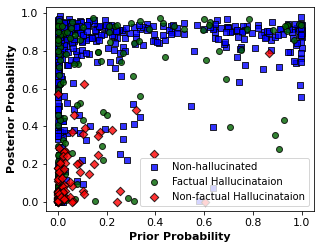

In [70]:
plot_three('entity_distribution_mlm_cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['blue','darkgreen', 'red'],
           x_label='Prior Probability',
           y_label='Posterior Probability',
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5),
           save_figure=True)

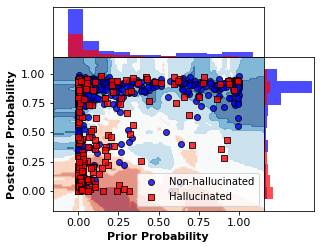

In [71]:
plot('hallucination_class',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-hallucinated'], save_figure=True)

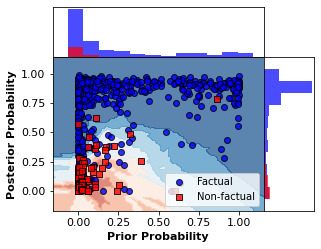

In [72]:
plot('factuality_class', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=20, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'],
     x_label='Prior Probability', y_label='Posterior Probability', save_figure=True)

#### Save KNN Model

In [73]:
import pickle

In [74]:
def build_KNN(posteriors, priors, labels, overlaps=None, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    if overlaps is not None:
        overlaps = np.array(overlaps)
        x_mat = np.vstack([posteriors, priors, overlaps]).transpose()
    else:
        x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [75]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, factual_label, overlaps=overlap_preds, n_neighbors=15)

In [76]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities, overlap_preds]).transpose()))

In [77]:
print(classification_report(factual_label, preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.6854    0.6854    0.6854        89
     Factual     0.9547    0.9547    0.9547       618

    accuracy                         0.9208       707
   macro avg     0.8200    0.8200    0.8200       707
weighted avg     0.9208    0.9208    0.9208       707



In [78]:
pickle.dump(knn_classifier, open('classifiers/knn_mlm_cmlm_3.pkl', 'wb'))

#### AUC

In [79]:
from draw import draw_auc

In [80]:
p1, p2, p3, p4, p5, p6, p7 = [], [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['bart.large'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_20000'])
        p4.append(p['cnndm_cmlm_cedar'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_10000'])
        p6.append(p['bart.large.xsum'])
#         p7.append(p['bart.large.cnn'])

assert len(p1) == len(factual_label)

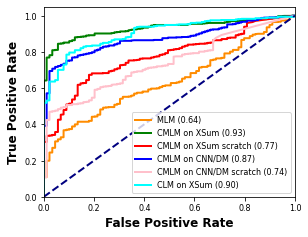

In [81]:
draw_auc(factual_label,
         [p1, p2, p3, p4, p5, p6],
         ['MLM', 'CMLM on XSum', 'CMLM on XSum scratch', 'CMLM on CNN/DM', 'CMLM on CNN/DM scratch', 'CLM on XSum'],
         ['darkorange', 'green', 'red', 'blue', 'pink', 'aqua'])

In [82]:
# draw_auc(factual_label,
#          [p2, p6, p4, p7],
#          ['CMLM on XSum', 'CLM on XSum', 'CMLM on CNN/DM', 'CLM on CNN/DM'],
#          ['darkorange', 'green', 'red', 'blue'])